In [25]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import keras_tuner as kt
import joblib

In [26]:
# Load the dataset
df = pd.read_csv("C:/Users/User/Desktop/Tree_classification/tree_classifier.csv")
print(df)

      Species\t  \tLength  Width   Ratio  Tip length  Base angle  no of veins  \
0         Betel      16.2   11.0    1.47         1.4         348            8   
1         Betel      12.6    9.1    1.38         1.1         312            8   
2         Betel      13.8    8.1    1.70         1.1         332            8   
3         Betel      12.1    8.5    1.42         1.1         322            8   
4         Betel      13.8   10.2    1.35         1.6         221            8   
..          ...       ...    ...     ...         ...         ...          ...   
70  Long pepper      13.3    9.8    1.36         0.6         228            6   
71  Long pepper      12.8    9.7    1.32         0.6         185            6   
72  Long pepper      10.9    9.0  121.00         0.8         230            6   
73  Long pepper      12.4   10.5    1.18         0.9         205            6   
74  Long pepper      14.0    9.7    1.44         0.8         206            6   

    petiole length  
0     

In [27]:
# Preprocess the data
# Convert species names to integers

# Strip leading and trailing spaces from column names
df.columns = df.columns.str.strip()

le = LabelEncoder()
df['Species'] = le.fit_transform(df['Species'])

In [28]:
# Split the dataset into training and test sets
X = df.drop(columns=['Species']).values
y = df['Species'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
# Save the scaler
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [31]:
# Build the model with Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=256, step=32),
                    activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=256, step=32),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='tree_classification')

Reloading Tuner from my_dir\tree_classification\tuner0.json


In [32]:
# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

In [33]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]


In [34]:
# Train the best model with EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = best_model.fit(X_train, y_train, epochs=50, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/50
2/2 [==============================] - 1s 242ms/step - loss: 0.7288 - accuracy: 0.8125 - val_loss: 0.5800 - val_accuracy: 1.0000
Epoch 2/50
2/2 [==============================] - 0s 41ms/step - loss: 0.6408 - accuracy: 0.9167 - val_loss: 0.5073 - val_accuracy: 1.0000
Epoch 3/50
2/2 [==============================] - 0s 48ms/step - loss: 0.6093 - accuracy: 0.8958 - val_loss: 0.4426 - val_accuracy: 1.0000
Epoch 4/50
2/2 [==============================] - 0s 49ms/step - loss: 0.5128 - accuracy: 0.9375 - val_loss: 0.3854 - val_accuracy: 1.0000
Epoch 5/50
2/2 [==============================] - 0s 35ms/step - loss: 0.4918 - accuracy: 0.9375 - val_loss: 0.3351 - val_accuracy: 1.0000
Epoch 6/50
2/2 [==============================] - 0s 33ms/step - loss: 0.4535 - accuracy: 0.9375 - val_loss: 0.2917 - val_accuracy: 1.0000
Epoch 7/50
2/2 [==============================] - 0s 50ms/step - loss: 0.4275 - accuracy: 0.9375 - val_loss: 0.2526 - val_accuracy: 1.0000
Epoch 8/50
2/2 [==========

In [35]:
# Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc}, Test loss: {test_loss}')

1/1 [==============================] - 0s 42ms/step - loss: 0.1953 - accuracy: 0.9333

Test accuracy: 0.9333333373069763, Test loss: 0.19528916478157043


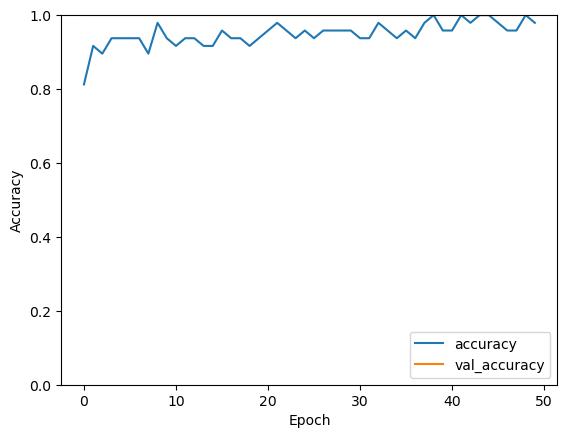

In [36]:
# Plotting the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

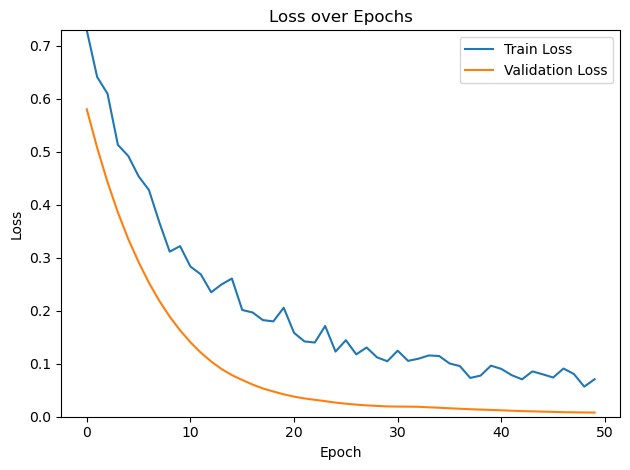

In [37]:
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, max(history.history['loss'])])
plt.title('Loss over Epochs')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [38]:
# Save the best model
best_model.save("C:/Users/User/Desktop/Tree_classification/best_model.h5")


In [39]:
# Load the best model
model = load_model("C:/Users/User/Desktop/Tree_classification/best_model.h5")

In [40]:
# Load the scaler
scaler = joblib.load('scaler.joblib')

In [41]:
# Load the dataset to get feature names
df = pd.read_csv("C:/Users/User/Desktop/Tree_classification/tree_classifier.csv")
df.columns = df.columns.str.strip()

In [42]:
# Get user input
def get_user_input():
    input_features = []
    feature_names = df.columns.drop('Species')  # Exclude the 'Species' column
    for feature in feature_names:
        value = float(input(f"Enter value for {feature}: "))
        input_features.append(value)
    return np.array(input_features).reshape(1, -1)

In [43]:
# Get user input
user_input = get_user_input()

Enter value for Length:  11
Enter value for Width:  8.2
Enter value for Ratio:  1.2
Enter value for Tip length:  1.1
Enter value for Base angle:  322
Enter value for no of veins:  8
Enter value for petiole length:  2.6


In [44]:
# Scale the user input
user_input_scaled = scaler.transform(user_input)


In [45]:
# Predict the class
predicted_class = model.predict(user_input_scaled)
predicted_class_index = np.argmax(predicted_class)


1/1 [==============================] - 0s 59ms/step


In [46]:
# Map class index to species name
species_names = {index: label for index, label in enumerate(le.classes_)}


In [47]:
# Print the predicted species name
print(f"Predicted class: {species_names.get(predicted_class_index, 'Unknown')}")

Predicted class: Betel
